In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os, time, gc
import requests, shutil
from skimage import io
from skimage.transform import resize

%matplotlib inline

# Load the data set

* There are totally 1,225,029 training images and 117,703 test images. 
* Totoally 14,951 landmarks

In [2]:
# Load the data
train = pd.read_csv('./data/all/train.csv')
test = pd.read_csv('./data/all/test.csv')

print('Train:\t\t', train.shape)
print('Test:\t\t', test.shape)

print('Landmarks:\t', len(train['landmark_id'].unique()))

Train:		 (1225029, 3)
Test:		 (117703, 2)
Landmarks:	 14951


In [3]:
train.head()

,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231


# Download Images

In [4]:
# Get single from the given url, modified from Kaggle kernel
# https://www.kaggle.com/abinesh100/easy-download-images-in-25-lines-py3/code
def fetch_image(url):
    """ Get image from given url """
    response=requests.get(url, stream=True)
    
    with open('./data/image.jpg', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
        
    del response

In [5]:
# Download images to ./train_images/
urls = train['url'].values
errors = []
t0 = time.time()

# Loop through urls to download images
for idx in range(len(urls)):
    url = urls[idx]
    # Helpful information
    if idx % 100000 == 0:
        t = time.time() - t0
        print('\nProcess: {:9d}'.format(idx), '   Used time: {} s'.format(np.round(t, 0)))
        t0 = time.time()
    if idx % 1250 == 0:
        print('=', end='')
    
    # Check if already downloaded
    if os.path.exists('./data/all/train_images/' + str(idx) + '.jpg'):
        continue
        
    try:
        # Get image from url
        fetch_image(url)
        os.rename('./data/image.jpg', './data/all/train_images/'+ str(idx) + '.jpg')
    except:
        errors.append(idx)
    
# Print error information
if len(errors) > 0:
    print('\nErrors:')
    for j in errors:
        print(j, '\t', urls[j])


Process:         0    Used time: 0.0 s
Process:    100000    Used time: 0.0 s
Process:    200000    Used time: 0.0 s
Process:    300000    Used time: 0.0 s
Process:    400000    Used time: 0.0 s
Process:    500000    Used time: 0.0 s
Process:    600000    Used time: 0.0 s
Process:    700000    Used time: 0.0 s
Process:    800000    Used time: 0.0 s
Process:    900000    Used time: 0.0 s
Process:   1000000    Used time: 0.0 s
Process:   1100000    Used time: 0.0 s
Process:   1200000    Used time: 0.0 s
Errors:
723431 	 http://celebhot.hol.es/picture/static.panoramio.com/photos/original/5340787.jpg
792934 	 http://r2.bru02t11.c.bigcache.googleapis.com/static.panoramio.com/photos/original/14185239.jpg?redirect_counter=1&st=ts&ir=1


In [6]:
# Download images to ./test_images/
urls = test['url'].values
errors = []
t0 = time.time()

# Loop through urls to download images
for idx in range(len(urls)):
    url = urls[idx]
    # Helpful information
    if idx % 10000 == 0:
        t = time.time() - t0
        print('\nProcess: {:9d}'.format(idx), '   Used time: {} s'.format(np.round(t, 0)))
        t0 = time.time()
    if idx % 125 == 0:
        print('=', end='')
    
    # Check if already downloaded
    if os.path.exists('./data/all/test_images/' + str(idx) + '.jpg'):
        continue
        
    try:
        # Get image from url
        fetch_image(url)
        os.rename('./data/image.jpg', './data/all/test_images/'+ str(idx) + '.jpg')
    except:
        errors.append(idx)
    
# Print error information
if len(errors) > 0:
    print('\nErrors:')
    for j in errors:
        print(j, '\t', urls[j])


Process:         0    Used time: 0.0 s
Process:     10000    Used time: 0.0 s
Process:     20000    Used time: 0.0 s
Process:     30000    Used time: 0.0 s
Process:     40000    Used time: 0.0 s
Process:     50000    Used time: 0.0 s
Process:     60000    Used time: 0.0 s
Process:     70000    Used time: 0.0 s
Process:     80000    Used time: 0.0 s
Process:     90000    Used time: 0.0 s
Process:    100000    Used time: 0.0 s
Process:    110000    Used time: 0.0 s

# Image Resize (256, 256, 3)

## Training set

In [7]:
# Iterate all images to resize and save images ==> (256, 256, 3)
ids = train['id'].values
urls = train['url'].values
landmark_ids = train['landmark_id'].values

train_id = []
train_url = []
train_label = []
errors = []

t0 = time.time()
idx = 0

for i in range(len(train)):
    # Helpful information
    if i % 100000 == 0:
        _ = gc.collect()   # cleanup
        t = time.time() - t0
        print('\nProcess: {:9d}'.format(i), '   Used time: {} s'.format(np.round(t, 0)))
        t0 = time.time()
    if i % 1250 == 0:
        print('=', end='')
        
    # Try to resize the valid images
    try:
        img = io.imread('./data/all/train_images/' + str(i) + '.jpg')
        resized = np.array(resize(img, (256, 256, 3), mode='reflect') * 255, dtype=np.uint8)
        io.imsave('./data/resized/train_resized/' + str(idx) + '.jpg', resized)
        train_id.append(ids[i])
        train_url.append(urls[i])
        train_label.append(landmark_ids[i])
        idx += 1
    except:
        errors.append(i)
        
train_df = pd.DataFrame({'id': train_id, 'url': train_url, 'landmark_id': train_label}, 
                        columns=['id', 'url', 'landmark_id'])

# Print error information
if len(errors) > 0:
    print('\nErrors:')
    for j in errors:
        print(j, '\t', urls[j])


Process:         0    Used time: 0.0 s
Process:    100000    Used time: 8216.0 s
Process:    200000    Used time: 8735.0 s
Process:    300000    Used time: 8981.0 s
Process:    400000    Used time: 9048.0 s
Process:    500000    Used time: 9109.0 s
Process:    600000    Used time: 9338.0 s
Process:    700000    Used time: 9525.0 s
Process:    800000    Used time: 9550.0 s
Process:    900000    Used time: 9095.0 s
Process:   1000000    Used time: 9080.0 s
Process:   1100000    Used time: 8887.0 s
Process:   1200000    Used time: 8867.0 s
Errors:
547 	 http://mw2.google.com/mw-panoramio/photos/medium/2600974.jpg
549 	 https://lh6.googleusercontent.com/-j6smQ5BpdOk/UwPAMPZCItI/AAAAAAAEoNk/9BNDH3XELsY/s1600/
1242 	 http://mw2.google.com/mw-panoramio/photos/small/6416081.jpg
1541 	 https://lh3.googleusercontent.com/--MpAp5fVUuQ/Ur-F8s_B-PI/AAAAAAAAEpU/iE7kX0BWlbM/s1600/
1721 	 http://lh4.ggpht.com/-EUIHWUoz2Z4/TOKBTAZtdtI/AAAAAAAAAe8/sbgWP0-IpZw/s1600/
2803 	 http://mw2.google.com/mw-panor

352146 	 http://lh6.ggpht.com/-_EpnKgm-YW4/TpnS7PSYkmI/AAAAAAAAUhM/FuYtGMNfXZY/s1600/
354009 	 http://static.panoramio.com/photos/original/106842534.jpg
354069 	 http://static.panoramio.com/photos/original/82190200.jpg
354116 	 http://lh5.ggpht.com/-Cq1QYDI6Vyo/Rjope9o70rI/AAAAAAAABw4/AL0lJhvheqA/s2048/
354233 	 http://mw2.google.com/mw-panoramio/photos/medium/6025145.jpg
354616 	 http://mw2.google.com/mw-panoramio/photos/medium/65065078.jpg
354871 	 http://static.panoramio.com/photos/original/97556000.jpg
354993 	 http://lh3.ggpht.com/-B380FSmHvX4/Sk2c9HI1N_I/AAAAAAAAG_U/J4MDf9Wfy-4/s2048/
355211 	 http://mw2.google.com/mw-panoramio/photos/medium/4721927.jpg
357098 	 http://lh5.ggpht.com/-yw0HSprNPmQ/RTQDWDWIABI/AAAAAAAAAZA/bDT7Zjlg_B8/s0/
360024 	 https://lh6.googleusercontent.com/-p098Y6-73dQ/UoOtPJsmnxI/AAAAAAAAAso/YCPkRZ3uWBw/s1600/
360730 	 http://mw2.google.com/mw-panoramio/photos/medium/8631738.jpg
361369 	 https://lh4.googleusercontent.com/-O_Zp_Xtjpc4/UvSVYnV5qnI/AAAAAAAAOoI/

688938 	 http://lh6.ggpht.com/-y2ZpAqUzjFg/TsPmBl8M5NI/AAAAAAAACVg/GlxZX8B1GPo/s1600/
688972 	 http://static.panoramio.com/photos/original/74909227.jpg
689279 	 http://static.panoramio.com/photos/original/73070572.jpg
689408 	 http://lh4.ggpht.com/-L8Sdq0cpSeQ/TzqPmoDLlHI/AAAAAAAAAqc/nLJMAier1GY/s2048/
690035 	 https://lh5.googleusercontent.com/-fj4LyNZ4qLM/Uu0ih110hoI/AAAAAAAAB3s/UlDxpDxvMaA/s1600/
690077 	 http://lh5.ggpht.com/-GiXrb1ouv20/TgNGXSn0FOI/AAAAAAAAQ8o/1pkenwYOH_8/s2048/
690429 	 http://mw2.google.com/mw-panoramio/photos/medium/63214471.jpg
692118 	 http://mw2.google.com/mw-panoramio/photos/medium/1096506.jpg
693015 	 https://lh3.googleusercontent.com/-50epytYyvCM/UhpDZ_6tROI/AAAAAAAAYWo/HIlfUk0x040/s1600/
693217 	 http://mw2.google.com/mw-panoramio/photos/medium/27185165.jpg
693618 	 https://lh5.googleusercontent.com/-HoLJV2UHpGQ/UXMMO54uOkI/AAAAAAAAAWM/BiTLCOF5VaI/s1600/
693910 	 http://static.panoramio.com/photos/original/82743857.jpg
694484 	 https://lh5.googleusercont

1018317 	 https://lh3.googleusercontent.com/-UwXBP8PRn20/Uwgr0N7uYOI/AAAAAAAACgY/qgLKCrsJaxA/s1600/
1018539 	 https://lh3.googleusercontent.com/-mu2yv67-05I/TtGXcLg5KSI/AAAAAAAAAl8/_FNqj7rwmRs/s1600/
1018703 	 http://mw2.google.com/mw-panoramio/photos/medium/65064157.jpg
1019339 	 http://lh6.ggpht.com/-9jVM-lQk19Q/SuBzMXr4MlI/AAAAAAAAADk/rGUvobYT0VM/s2048/
1019533 	 http://mw2.google.com/mw-panoramio/photos/medium/48952502.jpg
1019804 	 https://lh5.googleusercontent.com/-pT7J5j4JT_4/Uax6LlNyxVI/AAAAAAAATsA/Nad1UfbPleY/s1600/
1020064 	 http://mw2.google.com/mw-panoramio/photos/medium/11762540.jpg
1020191 	 https://lh5.googleusercontent.com/-731HDpfkpf0/UrZ9NzJLo0I/AAAAAAAABBU/YXeYwdjAYB0/s1600/
1020645 	 http://static.panoramio.com/photos/original/50728165.jpg
1020835 	 http://static.panoramio.com/photos/original/98110193.jpg
1021141 	 https://lh6.googleusercontent.com/-CfFD7QSUxt0/TrjpFVAIK1I/AAAAAAAACzU/yFJH6a_orCY/s1600/
1021299 	 http://lh6.ggpht.com/-WHeIK-qMIRM/Rwxub6E2rqI/AAAAAAA

In [20]:
# Save useful information
np.save('./data/errors/train_error_id.npy', errors)

train_df.to_csv('./data/resized/train_resized.csv', index=False)

error_url = [urls[k] for k in errors]

train_err_df = pd.DataFrame({'id': errors, 'url': error_url}, columns=['id', 'url'])
train_err_df.to_csv('./data/errors/train_error_df.csv', index=False)

In [22]:
train_df.head()

,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231


In [27]:
print('Original:\t', train.shape)
print('Resized:\t', train_df.shape)
print('Errors:\t\t', len(errors))

Original:	 (1225029, 3)
Resized:	 (1223295, 3)
Errors:		 1734


## Test set

In [28]:
# Iterate all images to resize and save images ==> (256, 256, 3)
ids = test['id'].values
urls = test['url'].values

test_id = []
test_url = []
test_errors = []

t0 = time.time()
idx = 0

for i in range(len(test)):
    # Helpful information
    if i % 10000 == 0:
        _ = gc.collect()   # cleanup
        t = time.time() - t0
        print('\nProcess: {:9d}'.format(i), '   Used time: {} s'.format(np.round(t, 0)))
        t0 = time.time()
    if i % 125 == 0:
        print('=', end='')
        
    # Try to resize the valid images
    try:
        img = io.imread('./data/all/test_images/' + str(i) + '.jpg')
        resized = np.array(resize(img, (256, 256, 3), mode='reflect') * 255, dtype=np.uint8)
        io.imsave('./data/resized/test_resized/' + str(idx) + '.jpg', resized)
        test_id.append(ids[i])
        test_url.append(urls[i])
        idx += 1
    except:
        test_errors.append(i)
        
test_df = pd.DataFrame({'id': test_id, 'url': test_url}, columns=['id', 'url'])

# Print error information
if len(test_errors) > 0:
    print('\nErrors:')
    for j in test_errors:
        print(j, '\t', urls[j])


Process:         0    Used time: 0.0 s
Process:     10000    Used time: 1158.0 s
Process:     20000    Used time: 841.0 s
Process:     30000    Used time: 827.0 s
Process:     40000    Used time: 840.0 s
Process:     50000    Used time: 838.0 s
Process:     60000    Used time: 929.0 s
Process:     70000    Used time: 823.0 s
Process:     80000    Used time: 893.0 s
Process:     90000    Used time: 863.0 s
Process:    100000    Used time: 870.0 s
Process:    110000    Used time: 878.0 s
Errors:
364 	 https://lh3.googleusercontent.com/-NTEBmt18KwM/WJjZ9QiT_5I/AAAAAAAAA8s/4l8JW917q5sJK8Seez6OZbq6L5M84fd_gCOcB/s1600/
396 	 https://lh3.googleusercontent.com/-jENluczx5W4/WPiSbbXdfEI/AAAAAAAAAmw/szoN5Sa4BjcswI34VMSPBGVCexKLhZ0rgCJkC/s1600-w640/
540 	 http://lh3.googleusercontent.com/-_l7Ozs5P7pY/VWB28Ro_B4I/AAAAAAAAB9c/mt3AU1lWjtE/s1600/
600 	 https://lh3.googleusercontent.com/-daemf8WYM-8/WJ7vRdM_2QI/AAAAAAAAg0A/QYVPqUQvHi06cOHJ-x2fVqgLFOU7X_9FgCOcB/s1600/
613 	 https://lh3.googleuserconten

In [30]:
# Save useful information
np.save('./data/errors/test_error_id.npy', test_errors)

test_df.to_csv('./data/resized/test_resized.csv', index=False)

test_error_url = [urls[k] for k in test_errors]

test_err_df = pd.DataFrame({'id': test_errors, 'url': test_error_url}, 
                           columns=['id', 'url'])
test_err_df.to_csv('./data/errors/test_error_df.csv', index=False)

In [31]:
print('Original:\t', test.shape)
print('Resized:\t', test_df.shape)
print('Errors:\t\t', len(test_errors))

Original:	 (117703, 2)
Resized:	 (117224, 2)
Errors:		 479


# Data Exploration

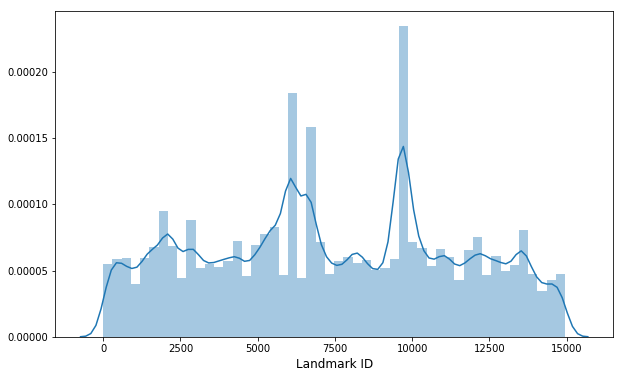

In [32]:
# Visualize the distribution of landmark ids
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(train['landmark_id'], ax=ax)
ax.set_xlabel('Landmark ID', fontsize=12)
plt.show()

In [33]:
# Group data according unique landmark_id
grouped = train[['landmark_id', 'id']].groupby('landmark_id').count().reset_index()
grouped = grouped.sort_values('id', ascending=False)
grouped = grouped.rename(columns={'id': 'count'}).reset_index(drop=True)

In [34]:
# Landmark with largest images
grouped.head()

,landmark_id,count
0,9633,50337
1,6051,50148
2,6599,23415
3,9779,18471
4,2061,13271


In [35]:
# Landmark with smallest images
grouped.tail()

,landmark_id,count
14946,11514,1
14947,4334,1
14948,6261,1
14949,6845,1
14950,7916,1


In [36]:
len(grouped[grouped['count'] < 10]) / len(grouped)

0.41234700020065546